In [3]:
import os
import sys

import pandas as pd
import numpy as np

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, utils
from torchvision.utils import save_image, make_grid

from transformers import ViTFeatureExtractor, ViTModel, ViTForImageClassification, ViTFeatureExtractor

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

## Данные и модель

In [4]:
from dataset import ArchDataset, GS_NEGATIVE_PATHS, GS_POSITIVE_PATHS, GS_NEGATIVE_COORDS, GS_POSITIVE_COORDS

In [5]:
from model import VQVAE

# Параметры модели и обучения

In [6]:
EMBED_DIM = 8
NUM_EMBEDS = 8

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [8]:
results_dir = f'../vq_vae_training_sasgis_results/v2_256pix_gray_{str(EMBED_DIM).zfill(2)}embdim_{str(NUM_EMBEDS).zfill(2)}embeds'
res_img_path = f'v2_256pix_gray_{str(EMBED_DIM).zfill(2)}embdim_{str(NUM_EMBEDS).zfill(2)}embeds'
checkpoint_path = f'{results_dir}/checkpoint_9.pth'

In [9]:
anomaly_scores_dir = f'results_basevit_lhs_{str(EMBED_DIM).zfill(2)}_{str(NUM_EMBEDS).zfill(2)}'
# os.mkdir(anomaly_scores_dir)

In [10]:
params = {
    'batch_size': 16,
    'img_size': 256,
    'channels': 1,
    'embedding_dim': EMBED_DIM,
    'num_embeddings': NUM_EMBEDS,
    'beta': 0.25,
    'n_epochs': 10,
}

# Датасет

In [11]:
transform_nocrop_256_grayscale = transforms.Compose([
    # transforms.CenterCrop((256, 256)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [12]:
torch.manual_seed(42);

In [13]:
train_dataset = ArchDataset(
    img_paths=GS_NEGATIVE_PATHS, 
    coords=GS_NEGATIVE_COORDS, 
    anomalies=False, 
    transform=transform_nocrop_256_grayscale
)
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=False)

anomalies_dataset = ArchDataset(
    img_paths=GS_POSITIVE_PATHS, 
    coords=GS_POSITIVE_COORDS, 
    anomalies=True, 
    transform=transform_nocrop_256_grayscale
)
anomalies_loader = DataLoader(anomalies_dataset, batch_size=params['batch_size'], shuffle=False)

In [14]:
print(f'train: {len(train_dataset)} images, {len(train_loader)} batches')
print(f'anomalies: {len(anomalies_dataset)} images, {len(anomalies_loader)} batches')

train: 99254 images, 6204 batches
anomalies: 165 images, 11 batches


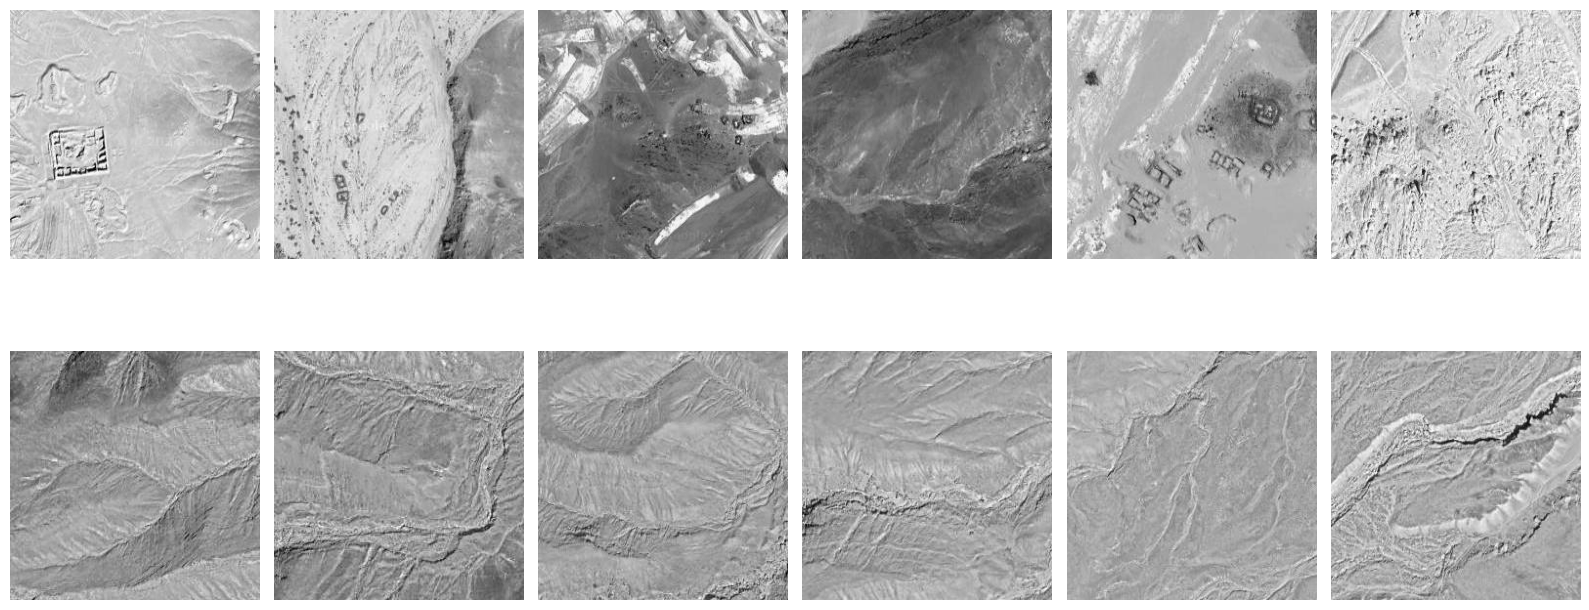

In [15]:
ncols = 6

fig, axs = plt.subplots(nrows=2, ncols=ncols, figsize=(16, 8))
for i in range(ncols):
    axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[0, i].imshow(anomalies_dataset[i][0].permute(1, 2, 0), cmap='gray')
    axs[1, i].imshow(train_dataset[i][0].permute(1, 2, 0), cmap='gray')
fig.tight_layout()
fig.show()

# Модель, восстанавливающая изображения

In [16]:
model = VQVAE(
    in_channels=params['channels'],
    img_size=params['img_size'],
    
    embedding_dim=params['embedding_dim'],
    num_embeddings=params['num_embeddings'],
    beta=params['beta']
)
model.to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval();

# Utils

In [17]:
def load_image(names):
    imgs = []
    for name in names:
        img = transform_nocrop_256_grayscale(Image.open(name).convert('RGB'))
        imgs.append(img)
    return imgs

def align_image(img):
    return (img - img.min()) / (img.max() - img.min())

def draw_image(imgs):
    fig, axes = plt.subplots(ncols=len(imgs) , figsize=(len(imgs) * 2, 2))

    if len(imgs) == 1:
        img = imgs[0]
        axes.imshow(align_image(img).permute(1, 2, 0))
    else:
        for i, img in enumerate(imgs): 
            axes[i].imshow(align_image(img).permute(1, 2, 0))
    plt.show()

# Вычисление anomaly score

In [18]:
MODEL_NAME = "google/vit-base-patch16-224"
vit_model = ViTModel.from_pretrained(MODEL_NAME)

vit_model.classifier = nn.Identity()
vit_model.to(device)
vit_model.eval();

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
vit_input_processor = transforms.Compose([
    transforms.Resize(224, antialias=False)
])

In [20]:
def extract_features(imgs):

    imgs = imgs.to(device)
    inputs = torch.stack([vit_input_processor(img) for img in imgs])
    inputs = torch.cat([inputs, inputs, inputs], dim=1)
    
    with torch.no_grad():
        outputs = vit_model(inputs)
        
    features = outputs.last_hidden_state[:, 1:, :]
    features = features.view(features.shape[0], -1)
    
    return features

In [21]:
def compute_anomaly_scores(data_loader, limit_batches=None):

    limit_batches = limit_batches if limit_batches is not None else len(data_loader)
    anomaly_scores_res = {}

    for batch_idx, batch in tqdm(enumerate(data_loader), total=limit_batches):
        
        if limit_batches and batch_idx >= limit_batches:
            break
        
        images, indices, _, _ = batch
        images = images.to(device)
        indices = indices.cpu().tolist()
        
        with torch.no_grad():
            restored_images, _, _ = model(images)

        feat_original = extract_features(images)
        feat_restored = extract_features(restored_images)
        
        cosine_sim = F.cosine_similarity(feat_original, feat_restored, dim=1)
        anomaly_scores_batch = (1 - cosine_sim).cpu().tolist()
        
        for (idx, score) in zip(indices, anomaly_scores_batch):
            anomaly_scores_res[idx] = score
            
    return anomaly_scores_res

In [22]:
anomaly_scores = compute_anomaly_scores(anomalies_loader)

100%|██████████| 11/11 [00:08<00:00,  1.29it/s]


In [ ]:
train_scores = compute_anomaly_scores(train_loader)

100%|██████████| 6204/6204 [33:13<00:00,  3.11it/s]


In [ ]:
with open(f'{anomaly_scores_dir}/anomalies.txt', 'w') as f:
    for idx, score in anomaly_scores.items():
        f.write(f"{idx}\t{score}\n")
        
with open(f'{anomaly_scores_dir}/train.txt', 'w') as f:
    for idx, score in train_scores.items():
        f.write(f"{idx}\t{score}\n")

## Считываем и смотрим

In [26]:
anomaly_scores = {}
with open(f'{anomaly_scores_dir}/anomalies.txt', 'r') as f:
    for line in f.readlines():
        idx, score = line.strip().split()
        anomaly_scores[int(idx)] = float(score)
        
train_scores = {}
with open(f'{anomaly_scores_dir}/train.txt', 'r') as f:
    for line in f.readlines():
        idx, score = line.strip().split()
        train_scores[int(idx)] = float(score)

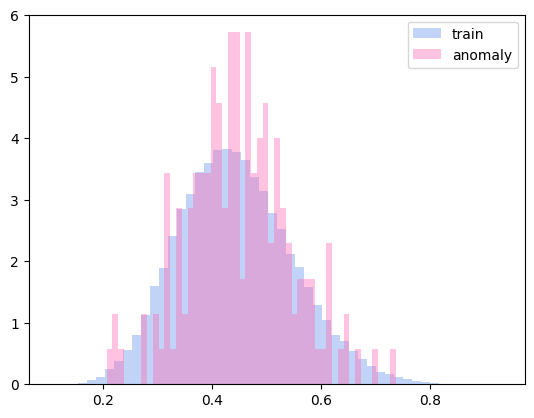

In [27]:
plt.hist(train_scores.values(), density=True, bins=50, alpha=0.4, label='train', color='cornflowerblue');
plt.hist(anomaly_scores.values(), density=True, bins=50, alpha=0.4, label='anomaly', color='hotpink');
plt.legend();
plt.savefig(f'{anomaly_scores_dir}/basevit_lhs_hist_{str(EMBED_DIM).zfill(2)}_{str(NUM_EMBEDS).zfill(2)}');

In [28]:
anomaly_scores_np = np.array(sorted(anomaly_scores.values()))
train_scores_np = np.array(sorted(train_scores.values()))

# Метрики

In [29]:
anomaly_scores_np = np.array(sorted(anomaly_scores.values()))
train_scores_np = np.array(sorted(train_scores.values()))

In [30]:
y_true = np.array([1] * len(anomaly_scores_np) + [0] * len(train_scores_np))
y_scores = np.concatenate((anomaly_scores_np, train_scores_np), axis=0)

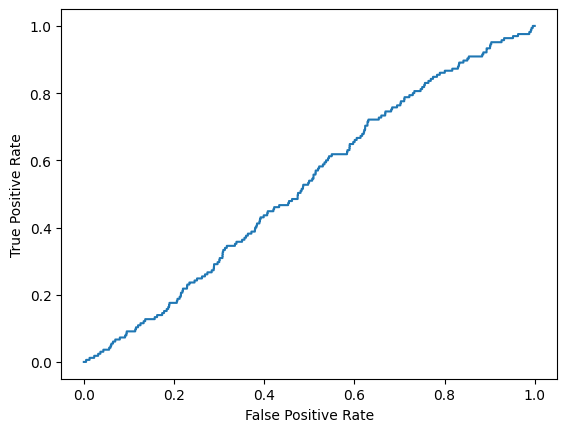

In [31]:
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.savefig(f'{anomaly_scores_dir}/basevit_lhs_roc_{str(EMBED_DIM).zfill(2)}_{str(NUM_EMBEDS).zfill(2)}');

In [32]:
precision_thresholds = np.array([0.80, 0.85, 0.90, 0.95])
thesholds = np.quantile(anomaly_scores_np, 1 - precision_thresholds)
percent_disproved = np.array([
    np.mean(train_scores_np < threshold)
    for threshold in thesholds
])

In [33]:
# сколько процентов данных отбрасываются из рассмотрения для фиксированного порого точности

for (pt, ast, pd) in zip(precision_thresholds, thesholds, percent_disproved):
    print(f'precision {pt:.02f} anomaly score threshold {ast:.02f} result {pd * 100:.02f}%')

precision 0.80 anomaly score threshold 0.38 result 26.97%
precision 0.85 anomaly score threshold 0.36 result 22.18%
precision 0.90 anomaly score threshold 0.34 result 15.26%
precision 0.95 anomaly score threshold 0.31 result 9.69%
